In [ ]:
# !wget https://github.com/vukbatanovic/SerbMR/releases/download/v1.0/SerbMR-2C.csv

In [1]:
import torch 
from fastai import *
from fastai.text import *
from fastai.core import *
from pathlib import Path
import pandas as pd
import numpy as np

#### Na osnovu Russian model-a: https://github.com/ademyanchuk/ulmfit-multilingual/blob/master/experiments/wiki-100-lm-rusent-class-v1.ipynb

# Train an AWD-LSTM language model

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *
from ulmfit.pretrain_lm import *

cuda_id = 0
torch.cuda.set_device(cuda_id)
bs = 8

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/sr-100/')

In [6]:
wiki_data_path.ls()

[PosixPath('data/wiki/sr-100/tmp_lm'),
 PosixPath('data/wiki/sr-100/sr.wiki.train.tokens'),
 PosixPath('data/wiki/sr-100/sr.wiki.valid.tokens'),
 PosixPath('data/wiki/sr-100/sr.wiki.test.tokens'),
 PosixPath('data/wiki/sr-100/models')]

In [7]:
# provide train and valid path
trn_path = wiki_data_path/'sr.wiki.train.tokens'
val_path = wiki_data_path/'sr.wiki.valid.tokens'

In [8]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [9]:
itos = data_lm.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.', ',', 'је', 'у', 'и', '\n \n ', '-', 'се', '\n ', 'на', "'", '&']


In [10]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(169160, 533)

In [11]:
data_lm.show_batch()

idx,text
0,факултета . xxmaj факултет послује под називом xxmaj правни факултет . xxmaj скраћен назив : xxup xxunk . xxmaj назив xxmaj факултета на енглеском језику је : - { & ' xxmaj xxunk of xxmaj law & ' } - . xxmaj седиште xxmaj факултета је на xxmaj новом xxmaj београду . xxmaj правни факултет има xxmaj дозволу за рад xxmaj министарства просвете xxmaj републике xxmaj србије број : 612
1,", а затим у xxmaj темишвару . xxmaj као стипендиста xxmaj матице српске завршио је студије у xxmaj бечу - правне науке и словенску филологију . xxmaj радио је као професор у xxmaj новосадској српској великој гимназији , почев од 1866 . године , пуне 33 године . у прво време је био и xxunk бележник бачке дијецезе . xxmaj био је старог xxunk , xxunk знања ; окупљао је"
2,"седамдесетих година 20 . века , али тек деценију касније и само у xxup сад , xxunk се термин & ' - { elder xxunk } - & ' , то јест , & ' насиље над старим лицима & ' . xxmaj насиље над старијим особама може бити физичко насиље , душевно насиље , сексуално насиље , економско насиље , xxunk и напуштање . \n \n xxmaj синдром"
3,", да сазива xxmaj скупштину , моћ да одобрава или ставља вето на законе које је донела xxmaj скупштина , да потписује xxunk , осим у случајевима издаје или xxunk . \n \n xxmaj четрдесет и шест особа је до сада служило на положају гувернера xxmaj њујорка , од којих је четири имало xxunk мандате . xxmaj укупно је било 60 мандата ; званични списак наводи сваког гувернера само"
4,"школу учио је у родном селу и xxmaj пироту , гимназију у xxmaj пироту , xxmaj нишу и xxmaj београду . xxmaj на xxmaj филозофском факултету у xxmaj београду 1912 . уписује се на xxmaj групи за историју опште , xxunk књижевности и историју уметности , где завршава пет xxunk . у xxmaj првом светском рату учествује у xxmaj xxunk батаљону , познатом као 1300 каплара . у бици на"


In [12]:
# save databunch
data_lm.save('tmp_lm')

In [13]:
# load databunch
data_lm = load_data(wiki_data_path, 'tmp_lm', bs=bs)

### Create Learner and train Language Model

In [14]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, arch=AWD_LSTM, drop_mult=0.9)

Unknown tokens 56282, first 100: ['xxfld', 'је', 'у', 'и', 'се', 'на', 'су', 'да', 'од', 'за', 'године', 'са', 'а', 'из', 'као', 'који', 'до', '„', 'био', 'по', 'која', 'или', 'што', 'које', 'становника', 'према', 'али', 'налази', 'о', 'није', 'након', 'била', 'то', 'код', 'би', 'не', 'када', 'око', 'под', 'током', 'било', 'има', 'због', 'година', 'све', 'први', 'где', 'још', 'га', 'само', 'док', 'више', 'између', 'може', 'тако', 'град', 'један', 'после', 'износи', 'време', 'od', 'такође', 'општина', 'два', 'како', 'били', 'с', 'три', 'ће', 'он', 'број', 'рата', 'део', 'па', 'века', 'касније', 'те', 'против', 'му', 'тога', 'дана', 'насеље', 'метара', 'своје', 'стране', 'неколико', 'становништва', 'јер', 'kao', 'две', 'већ', 'пре', 'преко', 'града', 'данас', 'србије', 'тада', 'општини', 'ово', 'други']


In [15]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [16]:
learner.metrics

[<function fastai.metrics.accuracy(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f7756b3bb70>>]

In [17]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm'),
                         partial(CSVLogger, filename=f"{learner.model_dir}/lm-history")]

In [18]:
# unfreeze all layers
learner.unfreeze()

In [19]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


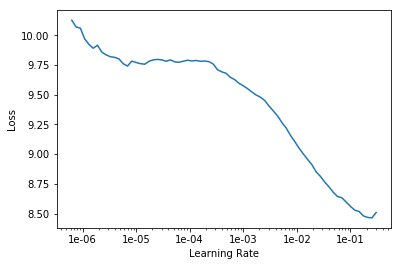

In [20]:
learner.recorder.plot(skip_end=15)

In [21]:
# define non-default momentums
moms=(0.8,0.7)

In [22]:
learner.fit_one_cycle(3, 1e-3) #, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
1,4.453520,4.456637,0.392037,11:28:04
2,4.420135,4.361069,0.407362,11:28:03
3,4.167873,4.297678,0.417120,11:28:05


In [23]:
# save model
learner.save('sr-100-best')
with open(wiki_data_path/'models/itos.pkl',"wb") as f:
    pickle.dump(data_lm.vocab.itos, f)

In [50]:
learner.predict('Ово је први модел језика на српском који', n_words=10)

'Ово је први модел језика на српском који је име написао у северозападном делу руске Републике'

In [5]:
# How to load model after kernel restart
wiki_data_path = Path('data/wiki/sr-100/')
loaded_data_lm = load_data(wiki_data_path, 'tmp_lm', bs=bs)
loaded_learner = language_model_learner(data=loaded_data_lm, arch=AWD_LSTM, drop_mult=0.9)
loaded_learner.load('sr-100-best')

Unknown tokens 56282, first 100: ['xxfld', 'је', 'у', 'и', 'се', 'на', 'су', 'да', 'од', 'за', 'године', 'са', 'а', 'из', 'као', 'који', 'до', '„', 'био', 'по', 'која', 'или', 'што', 'које', 'становника', 'према', 'али', 'налази', 'о', 'није', 'након', 'била', 'то', 'код', 'би', 'не', 'када', 'око', 'под', 'током', 'било', 'има', 'због', 'година', 'све', 'први', 'где', 'још', 'га', 'само', 'док', 'више', 'између', 'може', 'тако', 'град', 'један', 'после', 'износи', 'време', 'od', 'такође', 'општина', 'два', 'како', 'били', 'с', 'три', 'ће', 'он', 'број', 'рата', 'део', 'па', 'века', 'касније', 'те', 'против', 'му', 'тога', 'дана', 'насеље', 'метара', 'своје', 'стране', 'неколико', 'становништва', 'јер', 'kao', 'две', 'већ', 'пре', 'преко', 'града', 'данас', 'србије', 'тада', 'општини', 'ово', 'други']


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (169160 items)
x: LMTextList
xxbos = xxmaj правни факултет xxmaj универзитета xxmaj мегатренд = 
  xxmaj правни факултет xxmaj универзитета xxmaj мегатренд 
 
  xxmaj правни факултет xxmaj универзитета xxmaj мегатренд у xxmaj београду је високошколска установа са xxunk правног лица у саставу xxmaj универзитета xxmaj мегатренд ( групација друштвено - хуманистичких наука ) са правима , обавезама и xxunk утврђеним xxmaj законом о високом образовању , xxmaj статутом xxmaj универзитета и xxmaj статутом xxmaj факултета . xxmaj факултет послује под називом xxmaj правни факултет . xxmaj скраћен назив : xxup xxunk . xxmaj назив xxmaj факултета на енглеском језику је : - { & ' xxmaj xxunk of xxmaj law & ' } - . xxmaj седиште xxmaj факултета је на xxmaj новом xxmaj београду . xxmaj правни факултет има xxmaj дозволу за рад xxmaj министарства просвете xxmaj републике xxmaj србије број : 612 - 00 - xxunk / 2016 - 06 , од xxunk . год . xxmaj ста

In [6]:
loaded_learner.predict('Српска нација је јако стара, старија и од', n_words=5)

'Српска нација је јако стара, старија и од села Стара Француза'

In [40]:
# loaded_learner perplexity
math.exp(4.297678)
loaded_learner.validate()

[4.8230243, tensor(0.3714)]

### Fine tune on SerbMR unsupervised data

In [7]:
# !pip install transliterate
from transliterate import translit, get_available_language_codes
print(get_available_language_codes())

['sr', 'l1', 'bg', 'uk', 'ru', 'ka', 'el', 'mn', 'hy', 'mk']


In [35]:
df_train = pd.read_csv('data/serbmr/sr.train.csv', header=None)
df_test = pd.read_csv('data/serbmr/sr.test.csv', header=None)
df = pd.concat([df_train, df_test]) 
values = df[1].apply(translit, args=('sr',))
df[1] = values
print(df.shape)
df.head()

(1682, 2)


,0,1
0,POSITIVE,Један од најјачих адута европске кинематографи...
1,NEGATIVE,Желим у старту да се изјасним да нисам фан фра...
2,POSITIVE,Да ли си оно што си или оно што би желео да бу...
3,NEGATIVE,"Брокебацк моунтаин, чудесне године 'А сенсуал,..."
4,POSITIVE,Пријатељ ми је дуже време скретао пажњу да пог...


In [36]:
df.to_csv('data/serbmr/sr.unsup.csv', index=False, header=None)

In [8]:
# path for SerbMR data
serbmr_data_path = Path('data/serbmr/')
bs = 4
serbmr_data_path.ls()

[PosixPath('data/serbmr/sr.unsup.csv'),
 PosixPath('data/serbmr/prepare_serbmr.py'),
 PosixPath('data/serbmr/.ipynb_checkpoints'),
 PosixPath('data/serbmr/sr.test.csv'),
 PosixPath('data/serbmr/SerbMR-2C.csv'),
 PosixPath('data/serbmr/classes.txt'),
 PosixPath('data/serbmr/sr.train.csv'),
 PosixPath('data/serbmr/tmp_lm')]

In [9]:
# create LM DataBunch from SerbMR unsupervised corpus of review (https://vukbatanovic.github.io/SerbMR/)
data1_lm = TextLMDataBunch.from_csv(serbmr_data_path, 'sr.unsup.csv', text_cols=1, bs=bs)

In [10]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 34833
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'и', 'је', 'да', 'у', 'се', 'на', '(', ')', 'који', 'не']
data/serbmr


In [11]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(1344, 337)

In [11]:
data1_lm.show_batch()

idx,text
0,"xxunk до бољег снимка xxmaj вука са xxmaj вол xxmaj xxunk биће текст и за то па ћу коментарисати да ли је можда xxmaj лео заслужио оскара више од xxmaj метјуа али xxunk потом . xxmaj само бих поручио xxmaj xxunk фановима да не брину , пре или касније и он ће добити оскара . xxmaj мислим , xxmaj џејми xxmaj фокс има оскара . xxmaj зашто би та награда"
1,"комедија о судару култура кроз xxunk xxunk јунака у xxmaj америци , бескрајно више волим xxmaj партy xxmaj блакеа xxmaj xxunk . xxmaj но , xxmaj борат је трасх документарна комедија само по својој форми . xxmaj по својој суштини , ово дело спада у политичке драме с тезом . xxmaj нешто као xxmaj xxunk драме , само да су их којим случајем писали xxmaj xxunk и xxmaj xxunk трудећи"
2,", али је чова који је успео да преживи свакаква срања . xxmaj ако је већ успео да преживи сва та срања , онда је морао да има какво такво знање да може да се снађе у времену и простору . xxmaj овде имамо пар ситуација које он xxunk генијално . xxmaj али у пар сцена , ваљда да се сценаристи xxunk како је xxmaj меклејн матор и не мора"
3,"ми испричао ту причу ? ! ! xxmaj ето . xxmaj дошло ми . xxmaj каже лекар . xxmaj та прича је она црна кутија овог филма из које можете xxunk читав филм . xxmaj сви јунаци су то дете , са мукама у себи са којима не могу да се изборе и нико не може да им помогне . xxmaj читава xxmaj ирска је то болно тело које не"
4,"што ће се клинци навући на неке супер групе из саундтрека , заборавити филм и наставити да слушају супер музику . xxbos xxmaj филмови xxmaj давида xxmaj лyнцха обавезно изазивају поделе међу гледаоцима , како у тумачењу ( xxup шта се ту заправо десило ? ) тако и у xxunk ( xxup шта је ту толико добро ? ) . xxmaj судећи по xxunk приказима , изгледа да таква xxunk"


In [12]:
data1_lm.train_ds[0]

(<fastai.text.data.Text at 0x7fe1201879e8>,
 <fastai.core.EmptyLabel at 0x7fe1201876a0>)

In [12]:
# save data bunch 
data1_lm.save('tmp_lm')

In [13]:
data1_lm = load_data(serbmr_data_path, 'tmp_lm', bs=bs)

## Create Learner and Finetune model from pretrained fnames

In [14]:
# pretrained model and vocab from first step of training LM
# pretrained_fnames = ['sr-2-best', 'itos']
pretrained_fnames = ['sr-100-best', 'itos']

In [15]:
# create learner and provide pretrained files to finetune wiki-LM with serbMR data
learner = language_model_learner(data1_lm, AWD_LSTM, pretrained_fnames=pretrained_fnames, drop_mult=0.9, 
                                 model_dir='../wiki/sr-100/models')

Unknown tokens 34618, first 100: ['xxfld', 'и', 'је', 'да', 'у', 'се', 'на', 'који', 'не', 'за', 'су', 'што', 'од', 'са', 'као', 'филм', 'а', 'то', 'али', 'није', 'све', 'о', 'филма', 'из', 'би', 'која', 'сам', 'које', 'како', 'ће', 'само', 'или', 'овај', 'када', 'ово', 'по', 'до', 'тако', 'већ', 'он', 'више', 'ни', 'има', 'филму', 'нешто', 'још', 'ако', 'један', 'га', 'ми', 'шта', 'ту', 'може', 'па', 'јер', 'оно', 'прича', 'иако', 'овде', 'овог', 'тога', 'тхе', 'било', 'био', 'нема', 'му', 'можда', 'с', 'без', 'због', 'док', '„', 'нам', 'него', 'она', 'бити', 'баш', 'коју', 'толико', 'пре', 'мало', 'ствари', 'вам', 'треба', 'кроз', 'људи', 'те', 'ли', 'начин', 'много', 'колико', 'буде', 'овом', 'чак', 'своје', 'година', 'их', 'нису', 'филмова', 'приче']
Unknown tokens 17078, first 100: ['тхе', '’’', 'анд', 'браћо', 'гледалац', 'гледамо', 'сматрам', 'нисте', 'јохн', 'гледате', 'мицхаел', 'збиља', 'ваљда', 'забаван', 'гледам', 'замислите', 'нећете', 'јамес', 'погледао', 'клишеа', 'претп

In [16]:
learner.callback_fns += [partial(CSVLogger, filename=f"{learner.model_dir}/lm-history"),
                         partial(SaveModelCallback, every='epoch', name='lm')]

In [17]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


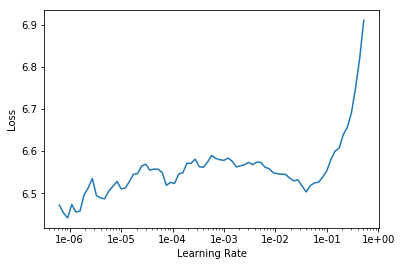

In [19]:
learner.recorder.plot(skip_end=15)

In [79]:
moms = (0.8, 0.7)

In [20]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 1e-2) #, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
1,6.121421,5.382051,0.245499,06:19


In [21]:
learner.save('fit_head')

In [22]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1344 items)
x: LMTextList
xxbos xxmaj не знам да ли вам се десило да дан после гледања филма не можете да се сетите xxunk вредног помена . xxmaj мени сигурно јесте . xxmaj очекивао сам много од овог филма а ево и зашто . xxmaj фан сам вестерна , оних класичних са xxmaj џон xxmaj вејном и компанијом . xxmaj нови вестерни могу се набројати на прсте једне руке , а нови а квалитетан још нисам погледао . xxmaj треба наравно да бацим око на xxmaj труе xxmaj грит , мада је и он римејк вестерна са xxmaj џон xxmaj вејном , и xxunk то xxmaj xxunk , који је , гле чуда , исто римејк . xxmaj тако да нове , квалитетне а оригиналне вестерне можемо набројати на прсте кишне xxunk . xxmaj друга ствар због које сам очекивао много су два главна глумца . xxmaj ма не , не мислим на xxmaj меган xxmaj фокс , рекао сам глумца , она , колико год била симпатична , нема баш способност глуме . xxmaj џош бролин је сјајан избор за насловну улогу и стварно опак

In [23]:
learner.unfreeze()

In [ ]:
learner.lr_find()

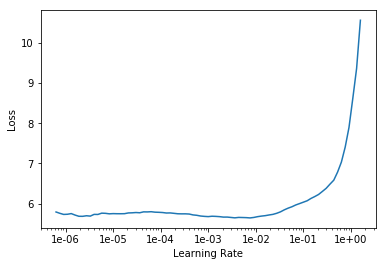

In [25]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5, 1e-3) #, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
1,9.396973,7.310815,0.098847,07:45


In [62]:
# save fine_tuned model
learner.save('fine_tuned')

In [63]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

In [66]:
# check text generation with LM
TEXT = translit("testiranjem ovog modela dobija se", 'sr')
N_WORDS = 10
N_SENTENCES = 2

In [67]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

тестирањем овог модела добија се налази се одвија у филму , Захваљујући затим
тестирањем овог модела добија се . Тхе Оф Тхе Добри
